### Импорт библиотек и выбор датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from tqdm.auto import tqdm
from summarizer import Summarizer
from evaluate import load

tqdm.pandas()

В качестве набора данных был выбран популярный датасет с обзором на книги от Амазона. Его нужно скачать для запуска ноутбука по [ссылке](https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews). Датасет содержит довольно большое количество информации о книге, но нам понадобится только review/summary и review/text - краткий и развёрнутый комментарий.

In [2]:
df = pd.read_csv("Books_rating.csv")

In [3]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


Оставим только нужные столбцы, удалим дубликаты и пропуски.

In [4]:
df = df[["review/summary", "review/text"]]
df = df.dropna()
df = df.drop_duplicates()

In [5]:
df.head()

,review/summary,review/text
0,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [6]:
print("размер датасета:", len(df))

размер датасета: 2067956


### Идея  

Основной идеей, на которой строится решение, стала суммаризация текста. Предположение заключается в том, что суммаризованный текст максимально семантически насыщен, т.к. из него удалена различная лишняя информация. Но использовать в качестве метрики просто отношение длины суммаризованного текста к обычному - не самая лучшая идея, потому что в той части текста, которая не включена в суммаризацию, может находиться хоть и не особо нужная, но семантически окрашенная информация. Поэтому её нужно учитывать, но с более меньшим весом. Для того, чтобы учесть её, можно считать bert_score между исходным текстом и суммаризированным. Та часть текста, которая входит в суммаризированный текст, будет давать единицу прироста bert-score'а, а которая не входит, будет давать долю прироста в зависимости от векторной схожести с суммаризованным текстом.  
Чтобы связать bert_score и отношение длины суммаризованного и исходного текста, можно использовать метод, схожий с f1-score (bert_score тут можно сравнить в некоторым аналогом recall'а, а отношение длин - с precision'ом).

### Реализация

In [187]:
model = Summarizer()
bertscore = load("bertscore")

Протестируем на первых 2000 сэмплах, т.к. такой подсчёт на процессоре занимает довольно много времени.

In [183]:
scores = []
for i in tqdm(range(2000)):
    full = df["review/text"].iloc[i]
    shorted = model(full, min_length=1)
    recall = bertscore.compute(predictions=[full], references=[shorted], lang="en", 
                  model_type="distilbert-base-uncased")["recall"][0]
    precision = len(shorted) / len(full)
    score = (2 * recall * precision) / (recall + precision + 1e-10)
    scores.append(score)

  0%|          | 0/2000 [00:00<?, ?it/s]

Посмотрим на распределения скора.

<Axes: ylabel='Count'>

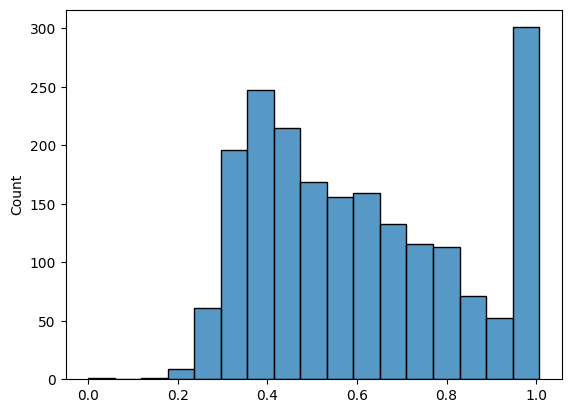

In [184]:
sns.histplot(scores)

У нас довольно много сэмплов, имеющих 100% скор и почти нет сэмплов с 0% насыщенности, что в целом является логичным. 

### Как можно улучшить?

В качестве улучшения можно попробовать дообучить суммаризатор на том датасете, для которого мы считаем метрику. Но это сильно снижает потенциал метода, т.к. требуется разметка. Ещё, возможно, можно прикрутить подсчёт косинусного расстояния между эмбеддингами суммаризированного и обычного текста.